In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime
#import optuna
import logging
import sys
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi


In [14]:
### THIS IS THE PAPERS MODEL WITH THEIR DATA ####

# Distribution types and parameter counts for PyTorch
distribution = 'Normal'
paramcount = {'Normal': 2,
              'StudentT': 3,
              'JSU': 4,
              'SinhArcsinh': 4,
              'NormalInverseGaussian': 4,
              'Point': None,
}

INP_SIZE = 221

# Country and distribution setup
cty = 'DE'

#if len(sys.argv) > 1:
#    cty = sys.argv[1]
#if len(sys.argv) > 2:
#    distribution = sys.argv[2]

#if not os.path.exists(f'../forecasts_probNN_{distribution.lower()}'):
#    os.mkdir(f'../forecasts_probNN_{distribution.lower()}')

#if not os.path.exists(f'../distparams_probNN_{distribution.lower()}'):
#    os.mkdir(f'../distparams_probNN_{distribution.lower()}')

#if not os.path.exists(f'../trialfiles'):
#    os.mkdir(f'../trialfiles')

print(cty, distribution)

#if cty != 'DE':
#    raise ValueError('Incorrect country')
#if distribution not in paramcount:
#    raise ValueError('Incorrect distribution')

# Read data
#data = pd.read_csv(f'../Datasets/{cty}.csv', index_col=0)
data = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/DE.csv', index_col=0)
data.index = [datetime.strptime(e, '%Y-%m-%d %H:%M:%S') for e in data.index]

class PricePredictionDataset(Dataset):
    def __init__(self, data, params):
        self.data = data
        #self.dayno = dayno
        self.params = params
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data

        Y = np.zeros((1456, 24))
        for d in range(1456):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], 'Price'].to_numpy()
        Y = Y[7:, :]  # skip first 7 days

        X = np.zeros((1456 + 1, INP_SIZE))
        for d in range(7, 1456 + 1):
            X[d, :24] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Price'].to_numpy()
            X[d, 24:48] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'Price'].to_numpy()
            X[d, 48:72] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'Price'].to_numpy()
            X[d, 72:96] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'Price'].to_numpy()
            X[d, 96:120] = df.loc[df.index[(d) * 24:(d + 1) * 24], df.columns[1]].to_numpy()
            X[d, 120:144] = df.loc[df.index[(d - 1) * 24:(d) * 24], df.columns[1]].to_numpy()
            X[d, 144:168] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], df.columns[1]].to_numpy()
            X[d, 168:192] = df.loc[df.index[(d) * 24:(d + 1) * 24], df.columns[2]].to_numpy()
            X[d, 192:216] = df.loc[df.index[(d - 1) * 24:(d) * 24], df.columns[2]].to_numpy()
            X[d, 216] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], df.columns[3]].to_numpy()
            X[d, 217] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], df.columns[4]].to_numpy()
            X[d, 218] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], df.columns[5]].to_numpy()
            X[d, 219] = self.data.loc[self.data.index[(d - 2) * 24:(d - 1) * 24:24], self.data.columns[6]].to_numpy()
            X[d, 220] = self.data.index[d].weekday()

        colmask = [False] * INP_SIZE
        if self.params['price_D-1']:
            colmask[:24] = [True] * 24
        if self.params['price_D-2']:
            colmask[24:48] = [True] * 24
        if self.params['price_D-3']:
            colmask[48:72] = [True] * 24
        if self.params['price_D-7']:
            colmask[72:96] = [True] * 24
        if self.params['load_D']:
            colmask[96:120] = [True] * 24
        if self.params['load_D-1']:
            colmask[120:144] = [True] * 24
        if self.params['load_D-7']:
            colmask[144:168] = [True] * 24
        if self.params['RES_D']:
            colmask[168:192] = [True] * 24
        if self.params['RES_D-1']:
            colmask[192:216] = [True] * 24
        if self.params['EUA']:
            colmask[216] = True
        if self.params['Coal']:
            colmask[217] = True
        if self.params['Gas']:
            colmask[218] = True
        if self.params['Oil']:
            colmask[219] = True
        if self.params['Dummy']:
            colmask[220] = True
        X = X[:, colmask]

        Xf = X[-1:, :]
        X = X[7:-1, :]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Model architecture in PyTorch
class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        if distribution == 'Normal':
            self.fc3 = nn.Linear(64, output_size * 2)  # loc and scale
        else:
            self.fc3 = nn.Linear(64, output_size * 3)  # different distribution params

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        if self.distribution == 'Normal':
            loc = x[:, :self.output_size]
            scale = F.softplus(x[:, self.output_size:])
            return loc, scale
        else:
            raise NotImplementedError(f"Distribution {self.distribution} not implemented.")

class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        # Calculate the negative log likelihood for a Normal distribution
        # log_prob = -0.5 * (log(2*pi) + log(scale^2) + (target - loc)^2 / scale^2)
        log_prob = -0.5 * (np.log(2 * torch.pi) + torch.log(scale**2) + (target - loc)**2 / (scale**2))
        return -torch.mean(log_prob)  # Negative because we want to minimize the log likelihood

# Training loop in PyTorch
def train_model(model, train_loader, val_loader, params):
    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = 500
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)  # Simplified, replace with distribution-based loss
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                val_loss += criterion(loc, scale, targets).item()

        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss / len(val_loader)}")

    return model  # Ensure this return is correctly indented


# Example of running the training loop
params = {
    'price_D-1': True,
    'price_D-2': True,
    'price_D-3': True,
    'price_D-7': True,
    'load_D': True,
    'load_D-1': True,
    'load_D-7': True,
    'RES_D': True,
    'RES_D-1': True,
    'EUA': True,
    'Coal': True,
    'Gas': True,
    'Oil': True,
    'Dummy': True,
    'learning_rate': 0.001,
}

# Example usage: assuming we are training on day 0
dataset = PricePredictionDataset(data, params)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
model = ProbNNModel(input_size=dataset.X.shape[1], output_size=24, distribution=distribution)

# Train the model
model = train_model(model, train_loader, val_loader, params)  # For simplicity using the same loader for train and validation


DE Normal


<ipython-input-14-74e5b498137c>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 216] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], df.columns[3]].to_numpy()
<ipython-input-14-74e5b498137c>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 217] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], df.columns[4]].to_numpy()
<ipython-input-14-74e5b498137c>:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[d, 218] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24

Epoch 1/500, Validation Loss: 34.967963790893556
Epoch 2/500, Validation Loss: 11.353205347061158
Epoch 3/500, Validation Loss: 7.965764713287354
Epoch 4/500, Validation Loss: 6.218051910400391
Epoch 5/500, Validation Loss: 5.497223305702209
Epoch 6/500, Validation Loss: 4.923271346092224
Epoch 7/500, Validation Loss: 4.617115092277527
Epoch 8/500, Validation Loss: 4.4251790046691895
Epoch 9/500, Validation Loss: 4.358293890953064
Epoch 10/500, Validation Loss: 4.310657238960266
Epoch 11/500, Validation Loss: 4.2942157745361325
Epoch 12/500, Validation Loss: 4.271550512313842
Epoch 13/500, Validation Loss: 4.255659008026123
Epoch 14/500, Validation Loss: 4.253618431091309
Epoch 15/500, Validation Loss: 4.245336055755615
Epoch 16/500, Validation Loss: 4.238521718978882
Epoch 17/500, Validation Loss: 4.22270565032959
Epoch 18/500, Validation Loss: 4.224987578392029
Epoch 19/500, Validation Loss: 4.217566967010498
Epoch 20/500, Validation Loss: 4.217866563796997
Epoch 21/500, Validation L

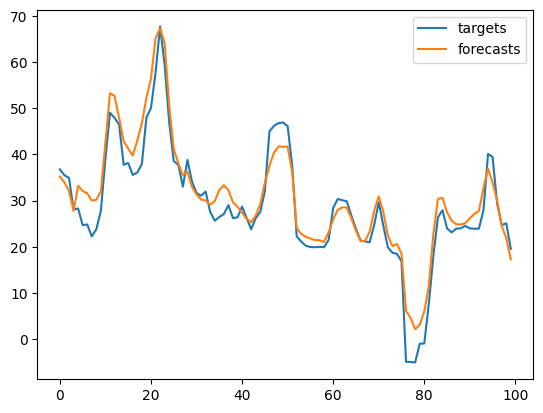

tensor(5.4283)


In [19]:
model.eval()
val_loss = 0
forecasts = []
targets = []
with torch.no_grad():
    for inputs, target in val_loader:
        loc, scale = model(inputs)
        forecasts.append(loc)
        targets.append(target)

targets_flat = torch.cat(targets,axis=0).flatten()
forecasts_flat = torch.cat(forecasts,axis=0).flatten()

plt.plot(targets_flat[-100:],label='targets')
plt.plot(forecasts_flat[-100:],label='forecasts')
plt.legend()
plt.show()


mse_loss = nn.MSELoss()
mse = mse_loss(forecasts_flat, targets_flat)
rmse = torch.sqrt(mse)
print(rmse)


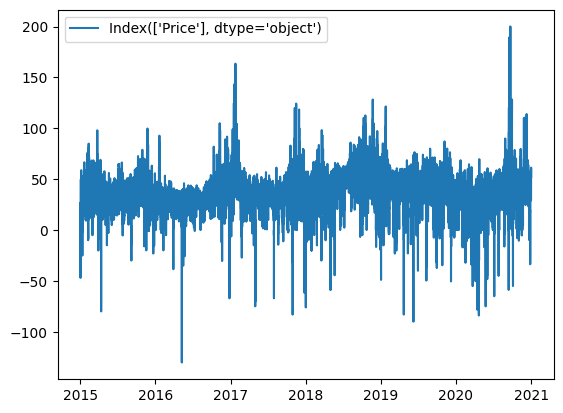

3


In [35]:
plt.plot(data.iloc[:,:1],label=data.columns[:1])
plt.legend()
plt.show()

print(data.index[0].weekday())

In [53]:
data_spain = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/formatted_data_withWeatherPrediction.csv')
data_with_transforms = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/formatted_data.csv')
res_gen_predicted = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi/data_santi/renewable_generation_predicted.csv',sep=";")
data_spain['Weekday'] = pd.to_datetime(data_spain[['Year', 'Month', 'Day']]).dt.weekday
cols_to_keep_indices = [0,1,2,3, 4, 5, 6, 7, 8, 9, 10, 11,-1, 39, 40, 44, 50, 51, 52, 56, 57, 58, -19, -20, 73 ,96, 97]
data_spain = data_spain.iloc[:, cols_to_keep_indices]
data_spain = pd.concat([data_spain,data_with_transforms.iloc[:,[-8,-7,-6,-5,-4,-3]]],axis=1)
data_spain['RES_gen_predicted'] = res_gen_predicted['value']
print(data_spain.columns,len(data_spain)/24,data_with_transforms.columns[-8:])


Index(['Year', 'Month', 'Day', 'Hour', 'DA', 'ID', 'Demand', 'Wind_Generation',
       'PV_Generation', 'Predicted_Demand', 'Price_EUR_MWh', 'Volume_MWh',
       'Weekday', 'Castile-La Mancha (Wind)_wind_u_component',
       'Castile-La Mancha (Wind)_wind_v_component',
       'Escatrón-Chiprana-Samper (Solar)_solar_radiation',
       'Madrid_solar_radiation', 'Madrid_wind_u_component',
       'Madrid_wind_v_component', 'Seville_solar_radiation',
       'Seville_wind_u_component', 'Seville_wind_v_component',
       'Madrid_wind_v_component_Predicted',
       'Madrid_wind_u_component_Predicted', 'Valencia_temperature',
       'Barcelona_wind_u_component_Predicted',
       'Barcelona_wind_v_component_Predicted', 'Hour_Sin', 'Hour_Cos',
       'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos', 'RES_gen_predicted'],
      dtype='object') 700.7916666666666 Index(['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos',
       'Year_Scaled', 'Diff'],
      dtype='object')


In [1]:
#### OUR MODEL ####


# Distribution types and parameter counts for PyTorch
distribution = 'Normal'
paramcount = {'Normal': 2,
              'StudentT': 3,
              'JSU': 4,
              'SinhArcsinh': 4,
              'NormalInverseGaussian': 4,
              'Point': None,
              }


class PricePredictionDataset(Dataset):
    def __init__(self, data, params):
        self.data = data
        #self.dayno = dayno
        self.params = params
        self.X, self.Y = self.prepare_data()

    def prepare_data(self):
        df = self.data

        Y = np.zeros((690, 24))
        for d in range(690):
            Y[d, :] = df.loc[df.index[d * 24:(d + 1) * 24], 'DA'].to_numpy()
        Y = Y[7:, :]  # skip first 7 days

        X = np.zeros((700 + 1, 726))
        for d in range(7, 690 + 1):
            X[d, :24] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'DA'].to_numpy()
            X[d, 24:48] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'DA'].to_numpy()
            X[d, 48:72] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'DA'].to_numpy()
            X[d, 72:96] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()
            X[d, 96:120] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'ID'].to_numpy()
            X[d, 120:144] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'ID'].to_numpy()
            X[d, 144:168] = df.loc[df.index[(d - 3) * 24:(d - 2) * 24], 'ID'].to_numpy()
            X[d, 168:192] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'ID'].to_numpy()
            X[d, 192:216] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Demand'].to_numpy()
            X[d, 216:240] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Demand'].to_numpy()
            X[d, 240:264] = df.loc[df.index[(d - 7) * 24:(d - 6) * 24], 'Demand'].to_numpy()
            X[d, 288:312] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Hour_Cos'].to_numpy()
            X[d, 336:360] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Hour_Sin'].to_numpy()
            X[d, 360] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Cos'].to_numpy()
            X[d, 361] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24:24], 'Day_Sin'].to_numpy()
            X[d, 362] = self.data.loc[self.data.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Cos'].to_numpy()
            X[d, 363] = self.data.loc[self.data.index[(d - 2) * 24:(d - 1) * 24:24], 'Month_Sin'].to_numpy()
            X[d, 364] = df.loc[df.index[(d) * 24:(d + 1) * 24:24], 'Weekday'].to_numpy()
            X[d, 365:389] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Madrid_wind_v_component_Predicted'].to_numpy()
            X[d, 389:413] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Madrid_wind_u_component_Predicted'].to_numpy()
            X[d, 413:437] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Barcelona_wind_v_component_Predicted'].to_numpy()
            X[d, 437:461] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Barcelona_wind_u_component_Predicted'].to_numpy()
            X[d, 461:485] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 485:509] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'Seville_solar_radiation'].to_numpy()
            X[d, 509:533] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Madrid_solar_radiation'].to_numpy()
            X[d, 533:557] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Seville_solar_radiation'].to_numpy()
            X[d, 557:581] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Castile-La Mancha (Wind)_wind_v_component'].to_numpy()
            X[d, 581:605] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Castile-La Mancha (Wind)_wind_u_component'].to_numpy()
            X[d, 605:629] = df.loc[df.index[(d) * 24:(d + 1) * 24], 'RES_gen_predicted'].to_numpy()
            X[d, 629:653] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'Wind_Generation'].to_numpy()
            X[d, 653:677] = df.loc[df.index[(d - 1) * 24:(d) * 24], 'PV_Generation'].to_numpy()
            X[d, 677:701] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'Wind_Generation'].to_numpy()
            X[d, 701:725] = df.loc[df.index[(d - 2) * 24:(d - 1) * 24], 'PV_Generation'].to_numpy()



        #colmask = [False] * INP_SIZE
        #if self.params['price_D-1']:
        #    colmask[:24] = [True] * 24
        #if self.params['price_D-2']:
        #    colmask[24:48] = [True] * 24
        #if self.params['price_D-3']:
        #    colmask[48:72] = [True] * 24
        #if self.params['price_D-7']:
        #    colmask[72:96] = [True] * 24
        #if self.params['load_D']:
        #    colmask[96:120] = [True] * 24
        #if self.params['load_D-1']:
        #    colmask[120:144] = [True] * 24
        #if self.params['load_D-7']:
        #    colmask[144:168] = [True] * 24
        #if self.params['RES_D']:
        #    colmask[168:192] = [True] * 24
        #if self.params['RES_D-1']:
        #    colmask[192:216] = [True] * 24
        #if self.params['EUA']:
        #    colmask[216] = True
        #if self.params['Coal']:
        #    colmask[217] = True
        #if self.params['Gas']:
        #    colmask[218] = True
        #if self.params['Oil']:
        #    colmask[219] = True
        #if self.params['Dummy']:
        #    colmask[220] = True
        #X = X[:, colmask]

        Xf = X[-1:, :]
        X = X[7:-1, :]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Model architecture in PyTorch
class ProbNNModel(nn.Module):
    def __init__(self, input_size, output_size, distribution):
        super(ProbNNModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.distribution = distribution

        # Define layers
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 220)
        self.fc2 = nn.Linear(220, 128)
        self.fc3 = nn.Linear(128, 64)

        if distribution == 'Normal':
            self.fc4 = nn.Linear(64, output_size * 2)  # loc and scale
        else:
            self.fc4 = nn.Linear(64, output_size * 3)  # different distribution params

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        if self.distribution == 'Normal':
            loc = x[:, :self.output_size]
            scale = 3e-3 + 3*F.softplus(x[:, self.output_size:])
            return loc, scale
        else:
            raise NotImplementedError(f"Distribution {self.distribution} not implemented.")

class NegativeLogLikelihood(nn.Module):
    def __init__(self):
        super(NegativeLogLikelihood, self).__init__()

    def forward(self, loc, scale, target):
        # Calculate the negative log likelihood for a Normal distribution
        # log_prob = -0.5 * (log(2*pi) + log(scale^2) + (target - loc)^2 / scale^2)
        log_prob = -0.5 * (np.log(2 * torch.pi) + torch.log(scale**2) + (target - loc)**2 / (scale**2))
        return -torch.mean(log_prob)  # Negative because we want to minimize the log likelihood

# Training loop in PyTorch
def train_model(model, train_loader, val_loader, params):
    criterion = NegativeLogLikelihood()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    epochs = 1500
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            loc, scale = model(inputs)
            loss = criterion(loc, scale, targets)  # Simplified, replace with distribution-based loss
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                loc, scale = model(inputs)
                val_loss += criterion(loc, scale, targets).item()

        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss / len(val_loader)}")

    return model  # Ensure this return is correctly indented


# Example of running the training loop
params = {
    'DA_D-1': True,
    'DA_D-2': True,
    'DA_D-3': True,
    'DA_D-7': True,
    'ID_D-1': True,
    'ID_D-2': True,
    'ID_D-3': True,
    'ID_D-7': True,
    'load_D': True,
    'load_D-1': True,
    'load_D-7': True,
    'Hour_cos_D': True,
    'Hous_sin_D': True,
    'Price_EUR_MWh': True,
    'Volume_MWh': True,
    'Weekday': True,
    'learning_rate': 0.0001,
}

# Example usage: assuming we are training on day 0
dataset = PricePredictionDataset(data_spain, params)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the model
model = ProbNNModel(input_size=dataset.X.shape[1], output_size=24, distribution=distribution)

# Train the model
model = train_model(model, train_loader, val_loader, params)  # For simplicity using the same loader for train and validation


NameError: name 'Dataset' is not defined

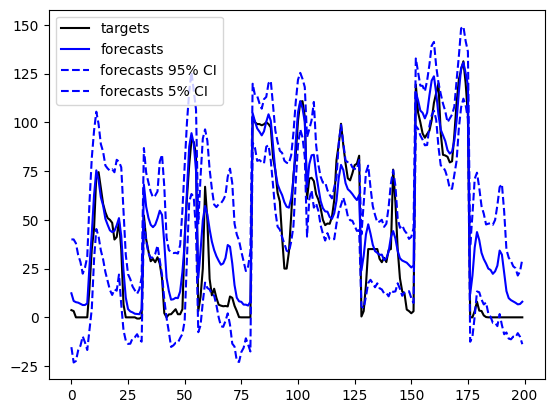

tensor(16.4400)


In [89]:
model.eval()
val_loss = 0
forecasts = []
scales = []
targets = []
with torch.no_grad():
    for inputs, target in val_loader:
        loc, scale = model(inputs)
        forecasts.append(loc)
        targets.append(target)
        scales.append(scale)

# Flatten the tensors into consistent shapes
targets_flat = torch.cat(targets, axis=0).flatten()
forecasts_flat = torch.cat(forecasts, axis=0).flatten()
scales_flat = torch.cat(scales, axis=0).flatten()  # Flatten scales to match forecasts_flat


plt.plot(targets_flat[-200:], label='targets', color='k')
plt.plot(forecasts_flat[-200:], label='forecasts', color='b')
plt.plot(forecasts_flat[-200:] + 1.96 * scales_flat[-200:], '--', color='b', label='forecasts 95% CI')
plt.plot(forecasts_flat[-200:] - 1.96 * scales_flat[-200:], '--', color='b', label='forecasts 5% CI')
plt.legend()
plt.show()


mse_loss = nn.MSELoss()
mse = mse_loss(forecasts_flat, targets_flat)
rmse = torch.sqrt(mse)
print(rmse)
